In [1]:
!wget https://raw.githubusercontent.com/JoseCaliz/dotfiles/main/css/gruvbox.css 2>/dev/null 1>&2
!pip install feature_engine 2>/dev/null 1>&2
    
from IPython.core.display import HTML
with open('./gruvbox.css', 'r') as file:
    custom_css = file.read()

HTML(custom_css)

# <div style="background-color:#D9C10B;text-align:center;color:white;font-size:150%;font-family:Literata;border-radius:10px"> <b>  Classifying buildings Post Hurricane using Satellite Imagery </b> </div>

> * The latest hurricane - Hurricane Iota, had 61 total fatalities, and 41 are still missing<br>
> * After a hurricane, damage assessment is vital to the relief helpers and first responders so that resources and help can be planned and allocated appropriately<br> 
> * One way to measure the damage is to detect and quantify the number of damaged buildings, usually done by driving around the affected area and noting down manually<br>
> * This process can be labor-intensive and time-consuming and not the most efficient method as well<br>
> * Hence in this project, our objective is to classify buildings between damaged and not damaged buildings using the satellite imagery data<br>
<div style = 'border: 2px solid #D9C10B;'>

## IMPORTING ALL NECESSARY LIBRARIES AND PACKAGES

In [2]:
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
import os
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras import Sequential,Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from pathlib import Path
from tensorflow.keras.utils import image_dataset_from_directory
import seaborn as sns

In [3]:
!pip install tf_keras_vis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 3.3 MB/s eta 0:00:00


In [4]:
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import BinaryScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from matplotlib import cm

## Firstly , we will be importing the images and labels to make them ready to be preprocessing

In [5]:
#directories for train, validation and test images
train_directory = Path('/kaggle/input/posthurricane/train_another') # the training data; 5000 images of each class(damage/no damage)
validation_directory = Path('/kaggle/input/posthurricane/validation_another') #the validation data; 1000 images of each class(damage/no damage)
unbalanced_test_directory = Path('/kaggle/input/posthurricane/test_another') # 8000/1000 images of damaged/undamaged classes
balanced_test_directory = Path('/kaggle/input/posthurricane/test') # the balanced test data; 1000 images of each class(damage/no damage)

#### **train_another** named dataset has two subfolders named **damage** and **no_damage**.
#### We will be storing the labels and the images separately in two lists for further operations

In [6]:
#Inialising empty lists for storing both of the damage and no_damage folders
labels_train,images_train,labels_test_another,images_test_another,labels_test,images_test = [],[],[],[],[],[]

for i in ['damage','no_damage']: 
    files_train = os.listdir(f'/kaggle/input/posthurricane/train_another/{i}')
    files_test_another =  os.listdir(f'/kaggle/input/posthurricane/test_another/{i}')
    files_test =  os.listdir(f'/kaggle/input/posthurricane/test/{i}')
    images_train.append(files_train)
    images_test_another.append(files_test_another)
    images_test.append(files_test)

    for l in range(len(files_train)):
        labels_train.append(i)
    for l in range(len(files_test)):
        labels_test_another.append(i)
    for l in range(len(files_test_another)):
        labels_test.append(i)
    
print("Number of items in the training set : {}".format(len(labels_train)))
    
print("Number of items in the test_another dataset : {}".format(len(labels_test_another)))
    
print("Number of items in the test dataset : {}".format(len(labels_test)))

Number of items in the training set : 10000
Number of items in the test_another dataset : 2000
Number of items in the test dataset : 9000


#### As the labels are stored as ***damage*** and ***no_damage***, we need to convert them into numerical values for training operations.For that, will be using **LabelEncoder** 

In [7]:
#Defining an instance of the LabelEncoder Class
label_en = LabelEncoder()
#Using label_en to transform the list
labels_all = [0]*3
labels_all[0] = label_en.fit_transform(labels_train)
labels_all[1] = label_en.transform(labels_test_another)
labels_all[2] = label_en.transform(labels_test)


#### We can see that the list is transformed into array named labels with the numerical values ***0 for damage*** and ***1 for no_damage***

In [8]:
print(labels_all[1])

[0 0 0 ... 1 1 1]


#### Let's visualise by a countplot the transformed labels array. We know that it should contain 5000 items for each class

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


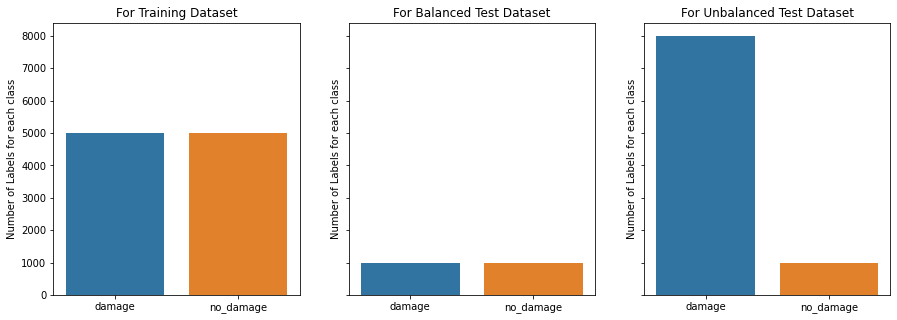

In [9]:
fig,ax = plt.subplots(1,3,figsize = (15,5),sharey = True)
classes = ['damage','no_damage']
sns.countplot(labels_all[0],ax = ax[0])
ax[0].set_title('For Training Dataset')
ax[0].set_xticklabels(classes)
ax[0].set_ylabel('Number of Labels for each class')
sns.countplot(labels_all[1],ax = ax[1])
ax[1].set_title('For Balanced Test Dataset')
ax[1].set_ylabel('Number of Labels for each class')
ax[1].set_xticklabels(classes)
sns.countplot(labels_all[2],ax = ax[2])
ax[2].set_title('For Unbalanced Test Dataset')
ax[2].set_ylabel('Number of Labels for each class')
ax[2].set_xticklabels(classes)
plt.show()

#### **Were there any Null values in the labels inserted while running the loop due to some errors? Let's check that**

In [10]:
#np.isnan(labels).any()

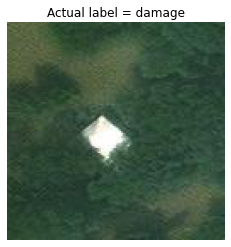

In [11]:
#quick image display with PIL
img1 = Image.open('/kaggle/input/posthurricane/train_another/damage/-93.55964_30.895018.jpeg') #train_damaged
plt.imshow(img1)
plt.title(f'Actual label = {labels_train[0]}')
plt.axis('off')
plt.show()

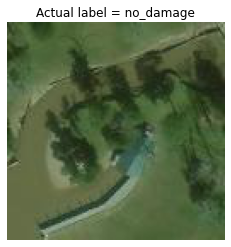

In [12]:
img2 = Image.open('/kaggle/input/posthurricane/train_another/no_damage/-95.061275_29.831535.jpeg') #train_undamaged
plt.imshow(img2)
plt.title(f'Actual label = {labels_train[5000]}')
plt.axis('off')
plt.show()

Our NumPy array has the shape: (128, 128, 3)


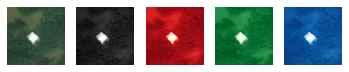

In [13]:
# Turn our image object into a NumPy array
img_data = np.array(img1)

# get the shape of the resulting array
img_data_shape = img_data.shape

print("Our NumPy array has the shape: {}".format(img_data_shape))

# plot the data with `imshow` 
fig,ax = plt.subplots(1,5)

ax[0].imshow(img_data)
ax[0].axis('off')
# grayscale image
ax[1].imshow(img_data[:,:,2], cmap='gray')
ax[1].axis('off')
# plot the red channel
ax[2].imshow(img_data[:,:,0], cmap=plt.cm.Reds_r)
ax[2].axis('off')
# plot the green channel
ax[3].imshow(img_data[:,:,1], cmap=plt.cm.Greens_r)
ax[3].axis('off')

# plot the blue channel
ax[4].imshow(img_data[:,:,2], cmap=plt.cm.Blues_r)
ax[4].axis('off')

plt.show()

In [14]:
train_gen = ImageDataGenerator(rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True,# horizontal flip
        rescale=1/255.0, #re-scaling
        brightness_range=[0.2,1.2]) # brightness)
validation_gen = ImageDataGenerator(rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        rescale=1/255.0, #re-scaling
        brightness_range=[0.2,1.2]) # brightness)
test_unbalanced_gen =  ImageDataGenerator()
test_balanced_gen =  ImageDataGenerator()

In [15]:
train_data = train_gen.flow_from_directory(
    directory = train_directory,
    target_size = (128,128),
    class_mode = 'binary',
    color_mode='rgb',
    shuffle = True,
    batch_size=100)

val_data = validation_gen.flow_from_directory(
    directory = validation_directory,
    target_size = (128,128),
    class_mode = 'binary',
    color_mode='rgb',
    shuffle = True,
    batch_size=100)
unbalanced_data = test_unbalanced_gen.flow_from_directory(directory =unbalanced_test_directory,
                                                          target_size = (128,128),
                                                          class_mode = 'binary',
                                                          shuffle = False,
                                                          color_mode='rgb',
                                                          batch_size=100)

balanced_data = test_balanced_gen.flow_from_directory(directory =balanced_test_directory,
                                                          target_size = (128,128),
                                                          class_mode = 'binary',
                                                          color_mode='rgb',
                                                          shuffle =False,
                                                          batch_size=100)


Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


# **Base Model**
<div style = 'border: 2px solid #D9C10B;'>

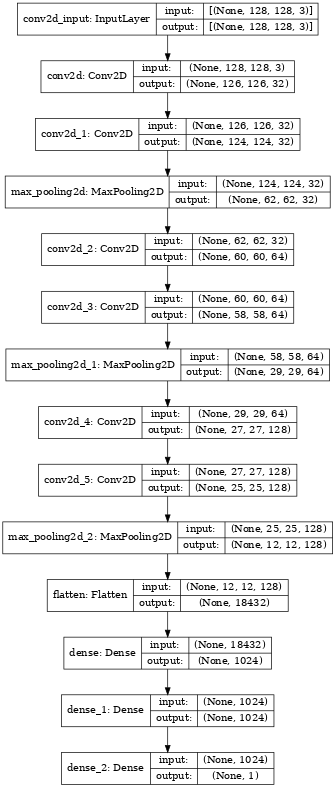

In [16]:
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,BatchNormalization,Dropout

# Initialize a sequential model
model = Sequential(name="Base_Model")


model.add(Conv2D(32,kernel_size =(3, 3), activation='relu',input_shape=(128,128,3)))
model.add(Conv2D(32,kernel_size =(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64,kernel_size =(3,3), activation='relu'))
model.add(Conv2D(64,kernel_size =(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128,kernel_size =(3,3), activation='relu'))
model.add(Conv2D(128,kernel_size =(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(1024,activation='relu'))
model.add(Dense(1024,activation='relu'))

model.add(Dense(1,activation = 'sigmoid'))
tensorflow.keras.utils.plot_model(model, "base_model.png", show_shapes=True,dpi =50)

In [17]:
# Compiling the model
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate = 1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
history_1 = model.fit(train_data,validation_data=val_data,epochs=10)

Epoch 1/10
100/100 [==============================] - 94s 859ms/step - loss: 0.6109 - accuracy: 0.6676 - val_loss: 0.6351 - val_accuracy: 0.6405
Epoch 2/10
100/100 [==============================] - 64s 643ms/step - loss: 0.4532 - accuracy: 0.8070 - val_loss: 0.4970 - val_accuracy: 0.7775
Epoch 3/10
100/100 [==============================] - 65s 646ms/step - loss: 0.3589 - accuracy: 0.8549 - val_loss: 0.3629 - val_accuracy: 0.8570
Epoch 4/10
100/100 [==============================] - 65s 646ms/step - loss: 0.2897 - accuracy: 0.8890 - val_loss: 0.2541 - val_accuracy: 0.8995
Epoch 5/10
100/100 [==============================] - 64s 643ms/step - loss: 0.2564 - accuracy: 0.8977 - val_loss: 0.2139 - val_accuracy: 0.9145
Epoch 6/10
100/100 [==============================] - 65s 654ms/step - loss: 0.2233 - accuracy: 0.9125 - val_loss: 0.2019 - val_accuracy: 0.9265
Epoch 7/10
100/100 [==============================] - 65s 651ms/step - loss: 0.1973 - accuracy: 0.9222 - val_loss: 0.2512 - val_ac

## Function for calculating the metrics

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
def metrices(model) :
    y_preds_unbalanced = [1 if prob >= 0.5 else 0 for prob in model.predict(unbalanced_data)]
    y_preds_balanced = [1 if prob >= 0.5 else 0 for prob in model.predict(balanced_data)]
    y_true_unbalanced = unbalanced_data.classes
    y_true_balanced = balanced_data.classes


    precision_unbalanced = precision_score(y_true_unbalanced, y_preds_unbalanced)
    recall_unbalanced = recall_score(y_true_unbalanced, y_preds_unbalanced)
    f1_unbalanced = f1_score(y_true_unbalanced, y_preds_unbalanced)
    roc_auc_unbalanced= roc_auc_score(y_true_unbalanced, y_preds_unbalanced)

    precision_balanced = precision_score(y_true_balanced, y_preds_balanced)
    recall_balanced = recall_score(y_true_balanced, y_preds_balanced)
    f1_balanced = f1_score(y_true_balanced, y_preds_balanced)
    roc_auc_balanced = roc_auc_score(y_true_balanced, y_preds_balanced)

    print('Precision on Unbalanced Test Dataset : {}'.format(precision_unbalanced ))
    print('Precision on Balanced Test Dataset : {}'.format(precision_balanced))

    print('Recall on Unbalanced Test Dataset : {}'.format(recall_unbalanced))
    print('Recall on Balanced Test Dataset : {}'.format(recall_balanced))

    print('F1 Score on Unbalanced Test Dataset : {}'.format(f1_unbalanced))
    print('F1 Score on Balanced Test Dataset : {}'.format(f1_balanced))

    print('AUC score  on Unbalanced Test Dataset : {}'.format(roc_auc_unbalanced))
    print('AUC score on Balanced Test Dataset : {}'.format(roc_auc_balanced))
     
    return precision_unbalanced,precision_balanced, recall_unbalanced,recall_balanced,f1_unbalanced,f1_balanced ,roc_auc_unbalanced,roc_auc_balanced

In [20]:
test_unbalanced_acc_1 = model.evaluate(unbalanced_data,verbose=0)
print('Test Accuracy of Specified Base Model on Unbalanced Test Dataset : {}'.format(test_unbalanced_acc_1[1] ))
test_balanced_acc_1= model.evaluate(balanced_data,verbose =0)
print('Test Accuracy of Specified Base Model on Balanced Test Dataset : {}'.format(test_balanced_acc_1[1] ))

metrics_1 = metrices(model)


# from IPython.display import clear_output
# count = 0
# labels = []
# for data, label in train_data:
#     labels.append(label)
#     count+=1
#     print(count)
#     clear_output(wait=True)

Test Accuracy of Specified Base Model on Unbalanced Test Dataset : 0.9596666693687439
Test Accuracy of Specified Base Model on Balanced Test Dataset : 0.9125000238418579
Precision on Unbalanced Test Dataset : 0.7940904893813481
Precision on Balanced Test Dataset : 0.961926091825308
Recall on Unbalanced Test Dataset : 0.86
Recall on Balanced Test Dataset : 0.859
F1 Score on Unbalanced Test Dataset : 0.8257321171387423
F1 Score on Balanced Test Dataset : 0.9075541468568411
AUC score  on Unbalanced Test Dataset : 0.9160624999999999
AUC score on Balanced Test Dataset : 0.9125


## Data visualization for base model

In [21]:
val_img1 = Image.open('/kaggle/input/posthurricane/validation_another/damage/-93.558326_30.895248.jpeg')
val_img2 = Image.open('/kaggle/input/posthurricane/validation_another/damage/-93.563851_30.894492.jpeg')
val_img3 = Image.open('/kaggle/input/posthurricane/validation_another/no_damage/-95.061894_30.007746.jpeg')
val_img4 = Image.open('/kaggle/input/posthurricane/validation_another/no_damage/-95.062123_30.056714000000003.jpeg')
val_img_labels = [0,0,1,1]
val_imgs = [val_img1,val_img2,val_img3,val_img4]

In [22]:
val_img_data = []
for img_data in val_imgs:
    data = np.array(img_data)
    data = data/255.0
    data = np.expand_dims(data,axis=0)
    #print(data.shape)
    val_img_data.append(data)

## Activation map for features extracted from first layer

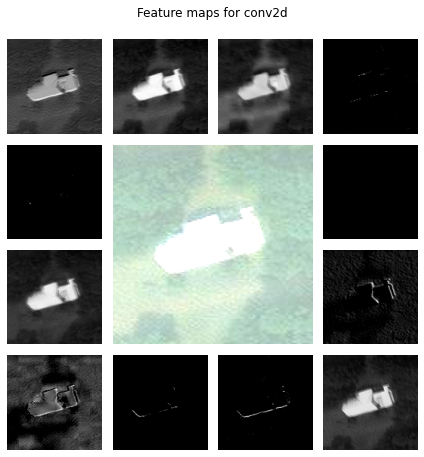

In [23]:
#Helper function used to plot the activation maps
def plot_featuremaps(img,activations,layer_names):
    fig, axs = plt.subplots(ncols=4, nrows=4,figsize = (6,6))
    gs = axs[1, 2].get_gridspec()
    # remove the underlying axes
    for ax in axs[1:-1, 1:-1]:
        ax[0].remove()
        ax[1].remove()
    axbig = fig.add_subplot(gs[1:-1, 1:-1])

    axbig.imshow(img.squeeze()+0.5)
    axbig.axis('off')

    for i, axis in enumerate(axs.ravel()):
        axis.imshow(activations.squeeze()[:,:,i], cmap='gray')
        axis.axis('off')

    fig.tight_layout()
    fig.suptitle(f'Feature maps for {layer_names[0]}',y=1.05);

first_conv_layer_output = model.layers[0].output
activation_model = Model(inputs=model.input,outputs=first_conv_layer_output)
activations = activation_model.predict(val_img_data[0])
plot_featuremaps(val_img_data[0],activations,[model.layers[0].name])

### Saliency maps

In [24]:
#Defining score function for saliency maps and GradCAM heatmap
def score_function(index):
    if (index==0 or index==1):
        score = BinaryScore(0.0)
    else:
        score = BinaryScore(1.0)
    return score

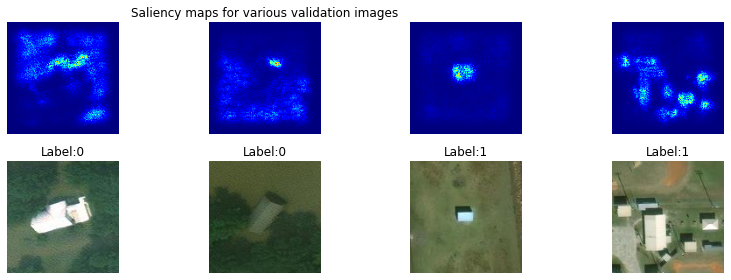

In [25]:
fig,ax = plt.subplots(2,4,figsize=(12, 4))

for i in range(4):
    saliency_model = Saliency(model,model_modifier=ReplaceToLinear(),clone=True)
    saliency_map = saliency_model(score_function(i),val_img_data[i])
    
    ax[1,i].imshow(val_imgs[i])
    ax[1,i].set_title(f'Label:{val_img_labels[i]}')
    ax[1,i].axis('off')

    ax[0,i].imshow(saliency_map[0], cmap='jet')
    ax[0,1].set_title('Saliency maps for various validation images')
    ax[0,i].axis('off')

plt.tight_layout()
plt.show()

### Grad CAM heatmaps

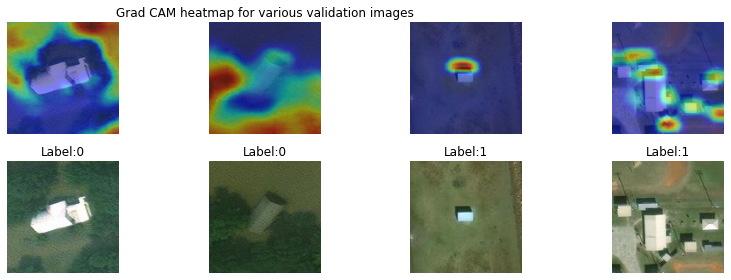

In [26]:
fig,ax = plt.subplots(2,4,figsize=(12, 4))

for i in range(4):
    gradcam = Gradcam(model,model_modifier=ReplaceToLinear(),clone=True)
    cam = gradcam(score_function(i),val_img_data[i])

    heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
    
    ax[1,i].imshow(val_imgs[i])
    ax[1,i].set_title(f'Label:{val_img_labels[i]}')
    ax[1,i].axis('off')

    ax[0,i].imshow(val_img_data[i][0])
    ax[0,i].imshow(heatmap[0], cmap='jet', alpha=0.5) # overlay
    ax[0,1].set_title('Grad CAM heatmap for various validation images')
    ax[0,i].axis('off')

plt.tight_layout()
plt.show()

# **Regularised Model**
<div style = 'border: 2px solid #D9C10B;'>

In [27]:
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten
from tensorflow.keras import regularizers
# Initialize a sequential model
model_reg = Sequential(name="Regularized_Model")


model_reg.add(Conv2D(32,kernel_size =(3, 3), activation='relu',input_shape=(128,128,3)))
model_reg.add(Conv2D(32,kernel_size =(3,3), activation='relu'))
model_reg.add(BatchNormalization())
model_reg.add(MaxPool2D(pool_size=(2, 2)))
model_reg.add(Conv2D(64,kernel_size =(3,3), activation='relu'))
model_reg.add(Conv2D(64,kernel_size =(3,3), activation='relu'))
model_reg.add(BatchNormalization())
model_reg.add(MaxPool2D(pool_size=(2, 2)))
model_reg.add(Conv2D(128,kernel_size =(3,3), activation='relu'))
model_reg.add(Conv2D(128,kernel_size =(3,3), activation='relu'))
model_reg.add(BatchNormalization())
model_reg.add(MaxPool2D(pool_size=(2, 2)))

model_reg.add(Flatten())

model_reg.add(Dense(1024,activation='relu'))
model_reg.add(Dropout(0.05))
model_reg.add(Dense(1024,activation='relu'))
model_reg.add(Dropout(0.05))

model_reg.add(Dense(1,activation = 'sigmoid'))

In [28]:
# Compiling the model
model_reg.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate = 1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
history_2 = model_reg.fit(train_data,validation_data=val_data,epochs=15)

Epoch 1/15
100/100 [==============================] - 66s 648ms/step - loss: 0.4627 - accuracy: 0.8004 - val_loss: 0.7013 - val_accuracy: 0.5000
Epoch 2/15
100/100 [==============================] - 64s 641ms/step - loss: 0.2952 - accuracy: 0.8822 - val_loss: 0.8664 - val_accuracy: 0.5000
Epoch 3/15
100/100 [==============================] - 66s 657ms/step - loss: 0.2353 - accuracy: 0.9053 - val_loss: 2.5660 - val_accuracy: 0.5000
Epoch 4/15
100/100 [==============================] - 65s 646ms/step - loss: 0.2059 - accuracy: 0.9155 - val_loss: 1.2086 - val_accuracy: 0.5090
Epoch 5/15
100/100 [==============================] - 65s 647ms/step - loss: 0.1910 - accuracy: 0.9214 - val_loss: 0.7495 - val_accuracy: 0.6135
Epoch 6/15
100/100 [==============================] - 64s 644ms/step - loss: 0.1772 - accuracy: 0.9273 - val_loss: 0.6549 - val_accuracy: 0.7480
Epoch 7/15
100/100 [==============================] - 64s 639ms/step - loss: 0.1636 - accuracy: 0.9349 - val_loss: 0.1957 - val_ac

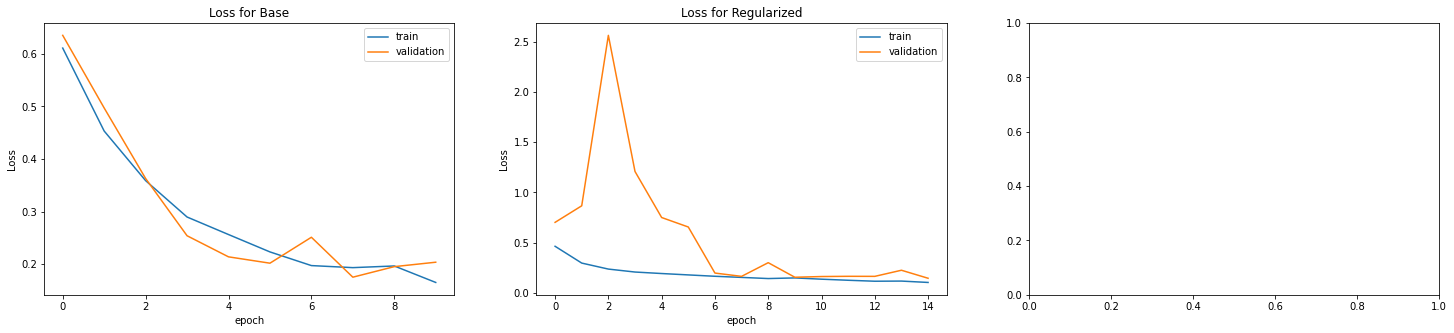

In [30]:
#Loss plots of Regularized and base model


fig, ax = plt.subplots(1,3,figsize = (25,5))
ax[0].plot(history_1.history['loss'])
ax[0].plot(history_1.history['val_loss'])
ax[0].legend(['train', 'validation'])
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss for Base')

ax[1].plot(history_2.history['loss'])
ax[1].plot(history_2.history['val_loss'])
ax[1].legend(['train', 'validation'])
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss for Regularized')


plt.show()

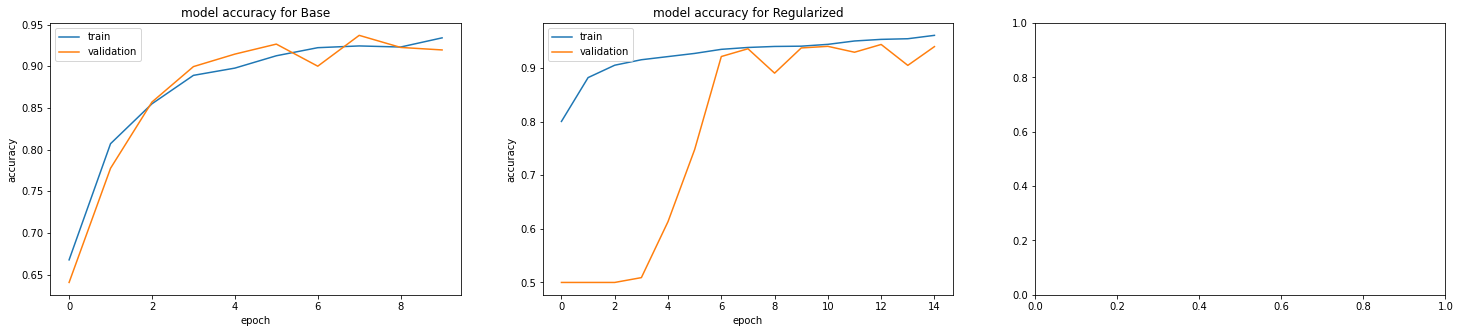

In [31]:
#Accuracy plots of Regularized and base model

fig, ax = plt.subplots(1,3,figsize = (25,5))
ax[0].plot(history_1.history['accuracy'])
ax[0].plot(history_1.history['val_accuracy'])
ax[0].legend(['train', 'validation'])
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('accuracy')
ax[0].set_title('model accuracy for Base')

ax[1].plot(history_2.history['accuracy'])
ax[1].plot(history_2.history['val_accuracy'])
ax[1].legend(['train', 'validation'])
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].set_title('model accuracy for Regularized')


plt.show()

In [32]:
test_unbalanced_acc_2 = model_reg.evaluate(unbalanced_data,verbose=0)
print('Test Accuracy of Regularised Model on Unbalanced Test Dataset : {}'.format(test_unbalanced_acc_2[1] ))
test_balanced_acc_2= model_reg.evaluate(balanced_data,verbose =0)
print('Test Accuracy of Regularised Model on Balanced Test Dataset : {}'.format(test_balanced_acc_2[1] ))

metrics_2 = metrices(model_reg)

Test Accuracy of Regularised Model on Unbalanced Test Dataset : 0.7294444441795349
Test Accuracy of Regularised Model on Balanced Test Dataset : 0.722000002861023
Precision on Unbalanced Test Dataset : 0.2547008547008547
Precision on Balanced Test Dataset : 0.7202380952380952
Recall on Unbalanced Test Dataset : 0.745
Recall on Balanced Test Dataset : 0.726
F1 Score on Unbalanced Test Dataset : 0.37961783439490443
F1 Score on Balanced Test Dataset : 0.7231075697211156
AUC score  on Unbalanced Test Dataset : 0.7362500000000001
AUC score on Balanced Test Dataset : 0.722


### Grad CAM heatmap for regularized model

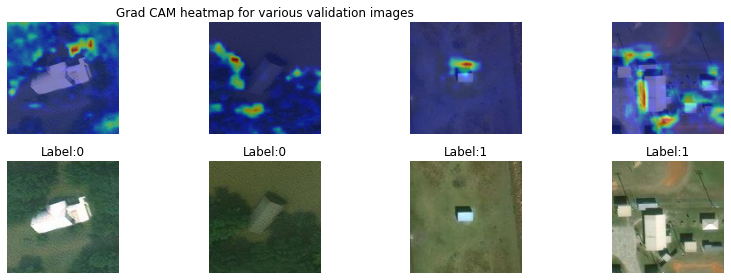

In [33]:
fig,ax = plt.subplots(2,4,figsize=(12, 4))

for i in range(4):
    gradcam = Gradcam(model_reg,model_modifier=ReplaceToLinear(),clone=True)
    cam = gradcam(score_function(i),val_img_data[i])

    heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
    
    ax[1,i].imshow(val_imgs[i])
    ax[1,i].set_title(f'Label:{val_img_labels[i]}')
    ax[1,i].axis('off')

    ax[0,i].imshow(val_img_data[i][0])
    ax[0,i].imshow(heatmap[0], cmap='jet', alpha=0.5) # overlay
    ax[0,1].set_title('Grad CAM heatmap for various validation images')
    ax[0,i].axis('off')

plt.tight_layout()
plt.show()

# SOTA Models
<div style = 'border: 2px solid #D9C10B;'>

 ### Now , we will be using the transfer learning approach to create different models using various SOTA models - ResNet-50, VGGNet (VGG19) , Inception-V3 and MobileNet

### We will be using pretrained weights from the ImageNet dataset. Although the ImageNet dataset do not satellite images , CNNs pre-trained on ImageNet have shown the ability to accurately predict even this category of classification

# ResNet-50
<div style = 'border: 2px solid #D9C10B;'>

### ResNet-50 is a 50 layer deep Neural Network architecture used for image classification and object detection

![](https://miro.medium.com/max/1100/0*9LqUp7XyEx1QNc6A.webp)

In [34]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input as prep_res
# Using the resnet architecture
ResNmodel = ResNet50(input_shape=(128,128,3),weights='imagenet',include_top = False)
# Importing the mobilenet model with pre-trained imagenet weights

ResNmodel = Model(inputs=ResNmodel.input, outputs=ResNmodel.layers[-1].output)

ResNmodel.layers[-1].output

94781440/94765736 [==============================] - 0s 0us/step


<KerasTensor: shape=(None, 4, 4, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [35]:
x=ResNmodel.output
x=Flatten()(x)
# On top of mobile net, add a few dense layers with 'relu' activation
# Using functional API, add a dense layer with 1024 neurons
x = Dropout(rate = 0.5)(x)
x=Dense(2048,activation= 'relu')(x)
x = Dropout(rate = 0.5)(x)
# Adding a dense layer with 512 neurons
x=Dense(1024,activation = 'relu')(x)
x = Dropout(rate = 0.5)(x)
x=Dense(512,activation = 'relu')(x)
x = Dropout(rate = 0.5)(x)
x= Dense(128,activation = 'relu')(x)
# Addinh a final layer with 1 neuron and sigmoid activation 
preds=Dense(1,activation = 'sigmoid')(x) 

In [36]:
model_resn=Model(ResNmodel.input,preds)

#### As the Resnet-50 accept the images og input shape (224,224,3), we are setting the target size of the images in flow_from_directory to br (224,224) and color_mode to be rgb

#### Creating a function that accepts the preprocessing_function and target size as parameters and returns the *train_data*, *validation_data*, *unbalanced_test_data* and *balanced_test_data* and they will be used for all the SOTA models

In [37]:
# Using the `ImageDataGenerator` function from keras to generate new images based on our existing ones
# Mentioning the preprocessing function as ResNet's preprocess_input and specify a9 validation split of 20%
def data_generator(preprocess_input,target_size):
        datagen=ImageDataGenerator(preprocessing_function=preprocess_input,rotation_range=10, # rotation
                                   width_shift_range=0.2, # horizontal shift
                                   height_shift_range=0.3, # vertical shift
                                   zoom_range=0.4, # zoom
                                   horizontal_flip=True,# horizontal flip
                                    #re-scaling
                                   brightness_range=[0.3,1.1]) # brightness)

        datagen_2=ImageDataGenerator(preprocessing_function=preprocess_input,rotation_range=10, # rotation
                                   width_shift_range=0.2, # horizontal shift
                                   height_shift_range=0.3, # vertical shift
                                   zoom_range=0.4, # zoom
                                   horizontal_flip=True,# horizontal flip
                                    #re-scaling
                                   brightness_range=[0.3,1.1])
        test_unbalanced_gen_2 =  ImageDataGenerator(preprocessing_function=preprocess_input)
        test_balanced_gen_2 =  ImageDataGenerator(preprocessing_function=preprocess_input)

        train_data=datagen.flow_from_directory(  directory = train_directory,
                                       target_size = target_size,
                                           class_mode = 'binary',
                                                                            
                                           batch_size=16)


        validation_data=datagen_2.flow_from_directory( directory = validation_directory,
                                              target_size = target_size,
                                                  class_mode = 'binary',
                                                  
                                                  batch_size=16)

        unbalanced_data = test_unbalanced_gen_2.flow_from_directory(directory =unbalanced_test_directory,
                                                          target_size = target_size,
                                                          class_mode = 'binary',
                                                          
                                                          batch_size=16)

        balanced_data = test_balanced_gen_2.flow_from_directory(directory =balanced_test_directory,
                                                          target_size = target_size,
                                                          class_mode = 'binary',
                                                          
                                                          batch_size=16)
        return train_data,validation_data,unbalanced_data,balanced_data


In [38]:
model_resn.compile(optimizer = tensorflow.keras.optimizers.Adam(2e-4),loss = tensorflow.keras.losses.BinaryCrossentropy(),metrics = ['accuracy'])

In [39]:
print(data_generator(prep_res,(128,128)))

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
(<keras.preprocessing.image.DirectoryIterator object at 0x79b01ba86490>, <keras.preprocessing.image.DirectoryIterator object at 0x79aff5f1c110>, <keras.preprocessing.image.DirectoryIterator object at 0x79b0ab3f5450>, <keras.preprocessing.image.DirectoryIterator object at 0x79b01ba732d0>)


#### ***Preprocess_input* for ResNet50 does the following preprocessing steps on the images**:

##### 1. Scaling the image values by the standard deviation of the ImageNet dataset

##### 2. The ResNet50 model was trained on the ImageNet dataset, which has a specific mean RGB value. This function subtracts these mean RGB values from the input image to ensure that the image has zero mean.

##### 3. The ResNet50 model was trained on images in the BGR color space, so this function converts the input image to the BGR color space.

In [40]:
train_data_1,validation_data_1,unbalanced_data_1,balanced_data_1 = data_generator(prep_res,(128,128))

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [41]:
step_size_train=train_data_1.n//train_data_1.batch_size
step_size_validation=validation_data_1.n//validation_data_1.batch_size

model_resn.fit(train_data_1,validation_data=validation_data_1,epochs =15,batch_size = 64)

Epoch 1/15
625/625 [==============================] - 81s 120ms/step - loss: 0.4876 - accuracy: 0.8383 - val_loss: 0.8166 - val_accuracy: 0.9065
Epoch 2/15
625/625 [==============================] - 75s 120ms/step - loss: 0.3604 - accuracy: 0.8987 - val_loss: 6.8122 - val_accuracy: 0.8165
Epoch 3/15
625/625 [==============================] - 75s 120ms/step - loss: 0.2027 - accuracy: 0.9230 - val_loss: 0.1632 - val_accuracy: 0.9380
Epoch 4/15
625/625 [==============================] - 75s 121ms/step - loss: 0.1375 - accuracy: 0.9492 - val_loss: 0.2364 - val_accuracy: 0.9040
Epoch 5/15
625/625 [==============================] - 74s 118ms/step - loss: 0.4656 - accuracy: 0.8715 - val_loss: 0.2162 - val_accuracy: 0.9400
Epoch 6/15
625/625 [==============================] - 73s 117ms/step - loss: 0.2145 - accuracy: 0.9208 - val_loss: 0.1155 - val_accuracy: 0.9540
Epoch 7/15
625/625 [==============================] - 73s 117ms/step - loss: 0.1576 - accuracy: 0.9448 - val_loss: 0.7604 - val_ac

In [42]:
test_unbalanced_acc_3 = model_resn.evaluate(unbalanced_data_1,verbose=0)
print('Test Accuracy of model_mn on Unbalanced Test Dataset : {}'.format(test_unbalanced_acc_3[1] ))
test_balanced_acc_3= model_resn.evaluate(balanced_data_1,verbose =0)
print('Test Accuracy of model_mn on Balanced Test Dataset : {}'.format(test_balanced_acc_3[1] ))
metrics_3 = metrices(model_resn)

Test Accuracy of model_mn on Unbalanced Test Dataset : 0.9548888802528381
Test Accuracy of model_mn on Balanced Test Dataset : 0.9284999966621399
Precision on Unbalanced Test Dataset : 0.15286384976525821
Precision on Balanced Test Dataset : 0.5928099779897286
Recall on Unbalanced Test Dataset : 0.814
Recall on Balanced Test Dataset : 0.808
F1 Score on Unbalanced Test Dataset : 0.2573913043478261
F1 Score on Balanced Test Dataset : 0.6838764282691494
AUC score  on Unbalanced Test Dataset : 0.6250625
AUC score on Balanced Test Dataset : 0.6265000000000001


# VGG-19
<div style = 'border: 2px solid #D9C10B;'>


### The VGG-19 model consists of 19 layers, including 16 convolutional layers, 3 fully-connected (FC) layers, and a final classification layer. It is a variant of the VGG-16 model, which was developed by the ***Visual Geometry Group*** group in the same year. Both models architecture are very simple yet effective

![](https://blog.techcraft.org/wp-content/uploads/2021/03/vgg19-architecture2.png)

In [43]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input as prep_vgg
# Using the VGGnet architecture
VGGmodel = VGG19(input_shape = (128,128,3),weights='imagenet',include_top = False)
# Importing the VGGnet model with pre-trained imagenet weights
# Discarding the last 1000 neuron layer ie. the final fully connected layer
VGGmodel = Model(inputs=VGGmodel.input, outputs=VGGmodel.layers[-3].output)
VGGmodel.layers[-3].output

80150528/80134624 [==============================] - 0s 0us/step


<KerasTensor: shape=(None, 8, 8, 512) dtype=float32 (created by layer 'block5_conv1')>

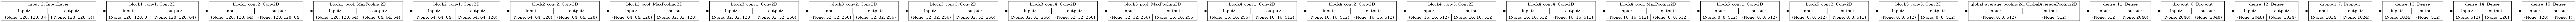

In [44]:
from keras.utils.vis_utils import plot_model
x=VGGmodel.output

x=GlobalAveragePooling2D()(x)
# On top of mobile net, add a few dense layers with 'relu' activation
# Using functional API, add a dense layer with 2048 neurons 
x=Dense(2048)(x)
x = Dropout(rate = 0.4)(x)
x=Dense(1024)(x)
x= Dropout(rate = 0.2)(x)
x=Dense(512)(x)
# Adding a dense layer with 512 neurons
x=Dense(128)(x)
# Addinh a final layer with 1 neuron and sigmoid activation 
preds=Dense(1,activation = 'sigmoid')(x) 

model_VGG=Model(VGGmodel.input,preds)

plot_model(model_VGG, to_file='model.png', show_shapes=True, rankdir='LR')

In [45]:
model_VGG.compile(optimizer = tensorflow.keras.optimizers.Adam(1e-4),loss = tensorflow.keras.losses.BinaryCrossentropy(),metrics = ['accuracy'])

#### ***Preprocess_input* for VGG19 does the following preprocessing steps on the images**:

##### 1. Resizing the input image to have the same size as the images used for training the VGG-19 model, but we overrode this using the target_size in flow_from_directory 

##### 2. The VGG-19 model was trained on images in the BGR color space, so the input images are converted to this color space before being fed into the model.

##### 3. Normalizing the pixel values of the input image.

In [46]:
train_data_2,validation_data_2,unbalanced_data_2,balanced_data_2 = data_generator(prep_vgg,(128,128))

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [47]:
step_size_train=train_data_2.n//train_data_2.batch_size
step_size_validation=validation_data_2.n//validation_data_2.batch_size

model_VGG.fit(train_data_2, steps_per_epoch=step_size_train,validation_data=validation_data_2,epochs =15, validation_steps=step_size_validation)

Epoch 1/15
625/625 [==============================] - 75s 116ms/step - loss: 0.5080 - accuracy: 0.8055 - val_loss: 0.1864 - val_accuracy: 0.9325
Epoch 2/15
625/625 [==============================] - 71s 114ms/step - loss: 0.1977 - accuracy: 0.9220 - val_loss: 0.1609 - val_accuracy: 0.9505
Epoch 3/15
625/625 [==============================] - 72s 114ms/step - loss: 0.1694 - accuracy: 0.9339 - val_loss: 0.1876 - val_accuracy: 0.9240
Epoch 4/15
625/625 [==============================] - 71s 114ms/step - loss: 0.1227 - accuracy: 0.9545 - val_loss: 0.2710 - val_accuracy: 0.9035
Epoch 5/15
625/625 [==============================] - 72s 115ms/step - loss: 0.1128 - accuracy: 0.9592 - val_loss: 0.2074 - val_accuracy: 0.9385
Epoch 6/15
625/625 [==============================] - 70s 112ms/step - loss: 0.1050 - accuracy: 0.9619 - val_loss: 0.1153 - val_accuracy: 0.9590
Epoch 7/15
625/625 [==============================] - 71s 114ms/step - loss: 0.0912 - accuracy: 0.9671 - val_loss: 0.1004 - val_ac

In [48]:
test_unbalanced_acc_4 = model_VGG.evaluate(unbalanced_data_2,verbose=0)
test_balanced_acc_4= model_VGG.evaluate(balanced_data_2,verbose =0)

In [49]:
print('Test Accuracy of model_VGG on Unbalanced Test Dataset : {:.3f}'.format(test_unbalanced_acc_4[1] ))
print('Test Accuracy of model_VGG on Balanced Test Dataset : {:.3f}'.format(test_balanced_acc_4[1] ))
metrics_4 = metrices(model_VGG)

Test Accuracy of model_VGG on Unbalanced Test Dataset : 0.991
Test Accuracy of model_VGG on Balanced Test Dataset : 0.989
Precision on Unbalanced Test Dataset : 0.4407979407979408
Precision on Balanced Test Dataset : 0.8604938271604938
Recall on Unbalanced Test Dataset : 0.685
Recall on Balanced Test Dataset : 0.697
F1 Score on Unbalanced Test Dataset : 0.5364134690681285
F1 Score on Balanced Test Dataset : 0.7701657458563536
AUC score  on Unbalanced Test Dataset : 0.7881875
AUC score on Balanced Test Dataset : 0.792


# Inception V-3
<div style = 'border: 2px solid #D9C10B;'>

### Inception v3 is a convolutional neural network (CNN) trained to classify images into a set of predefined classes. It was developed by Google researchers and was published in 2015 as part of the ILSVRC (ImageNet Large Scale Visual Recognition Challenge).It has also been used in a variety of research projects, including those focused on image recognition, object detection, and image generation.
#### Here, we would be using this architecture with pretrained(imagenet) weights for classification

![](https://media.geeksforgeeks.org/wp-content/uploads/20200502220903/Inception-V4.PNG)

In [50]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as prep_inc
INCmodel = InceptionV3(input_shape = (150,150,3),weights='imagenet',include_top = False)
# Importing the Inception V3 model with pre-trained imagenet weights
# Discarding the last 1000 neuron layer ie. the final fully connected layer
INCmodel = Model(inputs=INCmodel.input, outputs=INCmodel.layers[-3].output)

INCmodel.layers[-3].output

87924736/87910968 [==============================] - 0s 0us/step


<KerasTensor: shape=(None, 3, 3, 384) dtype=float32 (created by layer 'activation_91')>

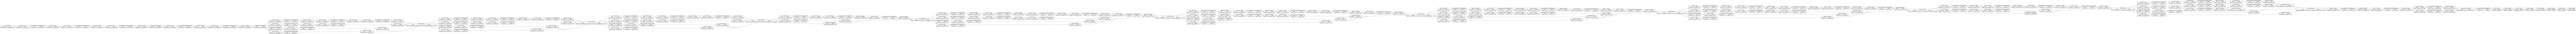

In [51]:
x=INCmodel.output
x=tensorflow.keras.layers.GlobalMaxPooling2D()(x)
# Using functional API, add a dense layer with 2048 neurons 
x=Dense(2048)(x)
x = Dropout(rate =0.5)(x)
# Adding a dense layer with 1024 neurons
x=Dense(1024)(x)
x = Dropout(rate =0.3)(x)
x=Dense(512)(x)
x = Dropout(rate =0.1)(x)
x=Dense(128)(x)
# Adding a final layer with 1 neuron and sigmoid activation 
preds=Dense(1,activation = 'sigmoid')(x) 

model_INC=Model(INCmodel.input,preds)
plot_model(model_INC, to_file='model.png', show_shapes=True, rankdir='LR')

#### ***Preprocess_input* for Inception- V3 does the following preprocessing steps on the images**:

##### 1. Resizing the input image to have the same size as the images used for training the Inception-v3 model, but we overrode this using the target_size in flow_from_directory 

##### 2. The Inception-V3 model was trained on images in the BGR color space, so the input images are converted to this color space before being fed into the model.

##### 3. Normalizing the pixel values of the input image.


In [52]:
train_data_3,validation_data_3,unbalanced_data_3,balanced_data_3 = data_generator(prep_inc,(150,150))

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [53]:
model_INC.compile(optimizer = tensorflow.keras.optimizers.Adam(2e-4),loss = tensorflow.keras.losses.BinaryCrossentropy(),metrics = ['accuracy'])

In [54]:
step_size_train=train_data_3.n//train_data_3.batch_size
step_size_validation=validation_data_3.n//validation_data_3.batch_size

model_INC.fit(train_data_3, steps_per_epoch=step_size_train,validation_data=validation_data_3,epochs =15, validation_steps=step_size_validation)

Epoch 1/15
625/625 [==============================] - 95s 142ms/step - loss: 0.3927 - accuracy: 0.8715 - val_loss: 0.1988 - val_accuracy: 0.9380
Epoch 2/15
625/625 [==============================] - 88s 140ms/step - loss: 0.1593 - accuracy: 0.9375 - val_loss: 0.1058 - val_accuracy: 0.9590
Epoch 3/15
625/625 [==============================] - 89s 143ms/step - loss: 0.1484 - accuracy: 0.9467 - val_loss: 0.1320 - val_accuracy: 0.9515
Epoch 4/15
625/625 [==============================] - 90s 144ms/step - loss: 0.1290 - accuracy: 0.9511 - val_loss: 0.1843 - val_accuracy: 0.9245
Epoch 5/15
625/625 [==============================] - 92s 148ms/step - loss: 0.1232 - accuracy: 0.9548 - val_loss: 0.1779 - val_accuracy: 0.9310
Epoch 6/15
625/625 [==============================] - 92s 147ms/step - loss: 0.0954 - accuracy: 0.9660 - val_loss: 0.1664 - val_accuracy: 0.9495
Epoch 7/15
625/625 [==============================] - 91s 145ms/step - loss: 0.0962 - accuracy: 0.9677 - val_loss: 0.0637 - val_ac

In [55]:
test_unbalanced_acc_5 = model_INC.evaluate(unbalanced_data_3,verbose=0)
test_balanced_acc_5= model_INC.evaluate(balanced_data_3,verbose =0)

In [56]:
print('Test Accuracy of model_INC on Unbalanced Test Dataset : {:.3f}'.format(test_unbalanced_acc_5[1] ))
print('Test Accuracy of model_INC on Balanced Test Dataset : {:.3f}'.format(test_balanced_acc_5[1] ))
metrics_5 = metrices(model_INC)

Test Accuracy of model_INC on Unbalanced Test Dataset : 0.977
Test Accuracy of model_INC on Balanced Test Dataset : 0.970
Precision on Unbalanced Test Dataset : 0.0
Precision on Balanced Test Dataset : 0.0
Recall on Unbalanced Test Dataset : 0.0
Recall on Balanced Test Dataset : 0.0
F1 Score on Unbalanced Test Dataset : 0.0
F1 Score on Balanced Test Dataset : 0.0
AUC score  on Unbalanced Test Dataset : 0.5
AUC score on Balanced Test Dataset : 0.5


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# MobileNet
<div style = 'border: 2px solid #D9C10B;'>

### MobileNet is a 53-layer deep Neural Network architecture designed for image classification and object detection tasks. Since it is fast and efficient, it works pretty well on resource-constraint systems and mobile devices. For this model as well, we will be using pre-trained imagenet weights as starting point of training

![](https://miro.medium.com/max/1100/1*7R068tzqqK-1edu4hbAVZQ.webp)

In [57]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input as prep_mob
MobNmodel = MobileNet(input_shape=(128,128,3),
    include_top=False,
    weights='imagenet')
MobNmodel = Model(inputs=MobNmodel.input, outputs=MobNmodel.layers[-1].output)

17235968/17225924 [==============================] - 0s 0us/step


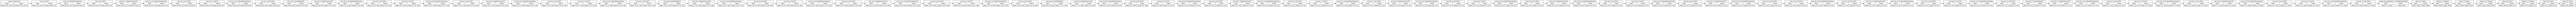

In [58]:
x=MobNmodel.output
x=tensorflow.keras.layers.GlobalMaxPooling2D()(x)
# Using functional API, add a dense layer with 2048 neurons 
x=Dense(2048)(x)
x = Dropout(rate =0.5)(x)
# Adding a dense layer with 1024 neurons
x=Dense(1024)(x)
x = Dropout(rate =0.3)(x)
x=Dense(512)(x)
x = Dropout(rate =0.1)(x)
x=Dense(128)(x)
# Adding a final layer with 1 neuron and sigmoid activation 
preds=Dense(1,activation = 'sigmoid')(x) 

model_MobN=Model(MobNmodel.input,preds)
plot_model(model_MobN, to_file='model2.png', show_shapes=True, rankdir='LR')

#### ***Preprocess_input* for MobileNet does the following preprocessing steps on the images**:

##### 1. It subtracts the mean pixel value from each of the pixels of the image to make then centered around 0

##### 2. Rescaling the images by dividing by 255

##### 3. Performing the channel-wise color normalization for each of the images


In [59]:
train_data_4,validation_data_4,unbalanced_data_4,balanced_data_4 = data_generator(prep_mob,(128,128))

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [60]:
model_MobN.compile(optimizer = tensorflow.keras.optimizers.Adam(2e-4),loss = tensorflow.keras.losses.BinaryCrossentropy(),metrics = ['accuracy'])

In [61]:
step_size_train=train_data_4.n//train_data_4.batch_size
step_size_validation=validation_data_4.n//validation_data_4.batch_size

model_MobN.fit(train_data_4, steps_per_epoch=step_size_train,validation_data=validation_data_4,epochs =15, validation_steps=step_size_validation)

Epoch 1/15
625/625 [==============================] - 73s 113ms/step - loss: 1.4704 - accuracy: 0.8476 - val_loss: 0.8708 - val_accuracy: 0.8330
Epoch 2/15
625/625 [==============================] - 69s 111ms/step - loss: 0.3465 - accuracy: 0.9064 - val_loss: 0.1417 - val_accuracy: 0.9525
Epoch 3/15
625/625 [==============================] - 69s 111ms/step - loss: 0.2459 - accuracy: 0.9248 - val_loss: 0.1138 - val_accuracy: 0.9575
Epoch 4/15
625/625 [==============================] - 69s 111ms/step - loss: 0.2040 - accuracy: 0.9377 - val_loss: 0.0884 - val_accuracy: 0.9630
Epoch 5/15
625/625 [==============================] - 70s 112ms/step - loss: 0.1519 - accuracy: 0.9491 - val_loss: 0.0852 - val_accuracy: 0.9660
Epoch 6/15
625/625 [==============================] - 69s 111ms/step - loss: 0.1331 - accuracy: 0.9520 - val_loss: 0.1291 - val_accuracy: 0.9375
Epoch 7/15
625/625 [==============================] - 70s 112ms/step - loss: 0.9458 - accuracy: 0.9212 - val_loss: 16.4695 - val_a

In [62]:
test_unbalanced_acc_6 = model_MobN.evaluate(unbalanced_data_4,verbose=0)
test_balanced_acc_6= model_MobN.evaluate(balanced_data_4,verbose =0)

In [63]:
print('Test Accuracy of model_INC on Unbalanced Test Dataset : {:.3f}'.format(test_unbalanced_acc_6[1] ))
print('Test Accuracy of model_INC on Balanced Test Dataset : {:.3f}'.format(test_balanced_acc_6[1] ))
metrics_6 = metrices(model_MobN)

Test Accuracy of model_INC on Unbalanced Test Dataset : 0.963
Test Accuracy of model_INC on Balanced Test Dataset : 0.979
Precision on Unbalanced Test Dataset : 0.05555555555555555
Precision on Balanced Test Dataset : 0.3333333333333333
Recall on Unbalanced Test Dataset : 0.001
Recall on Balanced Test Dataset : 0.001
F1 Score on Unbalanced Test Dataset : 0.0019646365422396855
F1 Score on Balanced Test Dataset : 0.0019940179461615153
AUC score  on Unbalanced Test Dataset : 0.4994374999999999
AUC score on Balanced Test Dataset : 0.49949999999999994


In [64]:
import plotly.subplots as sp
import plotly.graph_objs as go

classes = ['Unbalanced Test Accuracy','Balanced Test Accuracy','Unbalanced Test Precision','Balanced Test Precision','Unbalanced Test Recall','Balanced Test Recall','Unbalanced Test F1 Score','Balanced Test F1 Score','Unbalanced Test AUC score','Balanced Test AUC score']
x1 = classes
y1 = [test_unbalanced_acc_1[1],test_balanced_acc_1[1],metrics_1[0],metrics_1[1],metrics_1[2],metrics_1[3],metrics_1[4],metrics_1[5],metrics_1[6],metrics_1[7]]

x2 = classes
y2 =[test_unbalanced_acc_2[1],test_balanced_acc_2[1],metrics_2[0],metrics_2[1],metrics_2[2],metrics_2[3],metrics_2[4],metrics_2[5],metrics_2[6],metrics_2[7]]

x3 = classes
y3 = [test_unbalanced_acc_3[1],test_balanced_acc_3[1],metrics_3[0],metrics_3[1],metrics_3[2],metrics_3[3],metrics_3[4],metrics_3[5],metrics_3[6],metrics_3[7]]

x4 = classes
y4 = [test_unbalanced_acc_4[1],test_balanced_acc_4[1],metrics_4[0],metrics_4[1],metrics_4[2],metrics_4[3],metrics_4[4],metrics_4[5],metrics_4[6],metrics_4[7]]

x5 = classes
y5 = [test_unbalanced_acc_5[1],test_balanced_acc_4[1],metrics_5[0],metrics_5[1],metrics_5[2],metrics_5[3],metrics_5[4],metrics_5[5],metrics_5[6],metrics_5[7]]

x6 = classes
y6 = [test_unbalanced_acc_6[1],test_balanced_acc_6[1],metrics_6[0],metrics_6[1],metrics_6[2],metrics_6[3],metrics_6[4],metrics_6[5],metrics_6[6],metrics_6[7]]


trace1 = go.Bar(x=x1, y=y1,text =['{:.2f}'.format(v) for v in y1] ,name = 'Base Model')
trace2 = go.Bar(x=x2, y=y2,text =['{:.2f}'.format(v) for v in y2], name = 'Regularised Model')
trace3 = go.Bar(x=x3, y=y3 ,text =['{:.2f}'.format(v) for v in y3], name = 'ResNet-50 Model')
trace4 = go.Bar(x=x4, y=y4,text =['{:.2f}'.format(v) for v in y4], name = 'VGG-19 Model' )
trace5 = go.Bar(x=x5, y=y5,text =['{:.2f}'.format(v) for v in y5], name = 'Inception-V3 Model')
trace6 = go.Bar(x=x5, y=y5,text =['{:.2f}'.format(v) for v in y5], name = 'MobileNet Model')

fig = sp.make_subplots(rows=3, cols=2,subplot_titles=('Base Model', 'Regularised Model','ResNet-50 Model','VGG-19 Model','Inception-V3 Model','MobileNet Model'))
fig.update_layout(width=1000, height=1000)
fig.update_layout(title={'text': 'Accuracy comparison of various model architectures for the test datasets', 'x': 0.5, 'xanchor': 'center'} )
#fig.update_layout(plot_bgcolor='#DDDECE')
fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=1, col=2)
fig.add_trace(trace3, row=2, col=1)
fig.add_trace(trace4, row=2, col=2)
fig.add_trace(trace5, row=3, col=1)
fig.add_trace(trace6, row=3, col=2)
fig['layout']['yaxis']['title']='Accuracy'
fig['layout']['yaxis2']['title']='Accuracy'
fig['layout']['yaxis3']['title']='Accuracy'
fig['layout']['yaxis4']['title']='Accuracy'
fig['layout']['yaxis5']['title']='Accuracy'
fig['layout']['yaxis6']['title']='Accuracy'
fig.update_layout(yaxis2 = dict(range=[0, 1]))
fig.show()

### **Conclusions**
* According to the results obtained, we can infer that the base model gives the best accuracy among all the models.
* The use of pretrained weights of ImageNet helped us achieve better classification accuracy on unbalanced test dataset.
* The saliency maps and GradCAM heatmaps on the base and unregularized models captured the features of the images quite accurately.


### **Future Scope**
* We can further work on geo tags included in images names to understand the data better.
* We can further work on devising a more optimal model architecture giving comparable performance to those of SOTA models.